# Compute scattering of a strained parallelepipedic object, illuminated at different positions, on a 2D detector

This uses a kinematic sum to compute the scattered signal.

The illumination is computed as a Fresnel-Zone-Plate focused beam, and the scattering pattern
is computed for different lateral positions of the beam, like for a ptychography experiment.

In this example the calculation is done using OpenCL for the FZP illumination (CUDA is not implemented), whereas the scattering computation uses either CUDA or OpenCL (if OpenCL is used, it is important to give a GPU name to avoid selecting a CPU).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from pynx.scattering.fhkl import Fhkl_thread
from pynx.utils.rotation import rotate, rotation_matrix
from pynx.scattering.detector import detector2s
from pynx.utils.plot_utils import complex2rgbalin, complex2rgbalog, colorwheel
from pynx import wavefront
from pynx.wavefront import fzp
from scipy.fftpack import fftn, fftshift, ifftn
from scipy.interpolate import RegularGridInterpolator
import h5py as h5

# This can be used to have a wide display
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

# GPU name can be supplied, otherwise will be auto-selected
gpu_name ="GTX"
# Language for scattering calculations can also be given, or be auto-selected
language = "opencl"

## Create a 3D silicon crystal & rotate it to Bragg diffraction orientation
A step is used to limit the total number of scattering unit cells, and get a faster computing. It is important to keep the final sampling small enough to avoid aliasing issues. For `step=10` the sampling is 5.4nm, below the pixel size of the back-propagated wavefront in the last cell. You can try `step=10` to see if it makes a difference.

In [2]:
a = 5.4309e-10
wavelength = 1.5e-10

nx=1000
ny=100
nz=800

step = 10  # One scatterer every step x step x step cell for faster calculations...

# Create array of 3D scattering coordinates
x = np.arange(0, nx, step, dtype=np.float32)
y = np.arange(0, ny, step, dtype=np.float32)[:, np.newaxis]
z = np.arange(0, nz, step, dtype=np.float32)[:, np.newaxis, np.newaxis]
x = (x-x.mean()) * a
y = (y-y.mean()) * a
z = (z-z.mean()) * a

# Add some inhomogeneous strain
y = y - 1e-9 * ((x/ x.max())**2 + (z / z.max())**2)

print("Number of scattering points: %8.5e" % (nx * ny * nz / step**3))

# Rotate crystal in diffraction condition
theta = np.arcsin(wavelength / 2 / (a/4))
print("2theta = %6.2f°" % (2 * np.rad2deg(theta)))
m = rotation_matrix('x', theta)
x, y, z = rotate(m, x, y, z)

Number of scattering points: 8.00000e+04
2theta =  67.06°


## Create detector
The reciprocal space coordinates on the detector are calculated, taking into account Ewald's sphere curvature.

In [3]:
nxd, nyd = 516, 516
pixel_size = 55e-6
distance= 1.2
x0, y0 = nxd/2, nyd/2
rotation_axes= ('x', 2 * theta), ('y', 0)

sx, sy, sz = detector2s(nxd, nyd, pixel_size, distance, x0, y0, rotation_axes, wavelength)

# HKL coordinates on detector
m = rotation_matrix('x', -theta)
h, k, l = rotate(m, sx, sy, sz)
h /= 1/a
k /= 1/a
l /= 1/a
print("Average HKL coordinates: %5.3f %5.3f %5.3f" %(h.mean(), k.mean(), l.mean()))
print("Total number of scattering points: %8.5e" % h.size)

Average HKL coordinates: 0.000 -4.000 -0.000
Total number of scattering points: 2.66256e+05


## Compute Fresnel-Zone Plate illumination
..or re-use the probe from a ptychography experiment

FZP: diameter= 300.00um, focal length= 14.00cm


/Users/vincent/dev/py38-env/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


clFZP dt=  1.55122s,  1063.21 Gflop/s


<IPython.core.display.Javascript object>


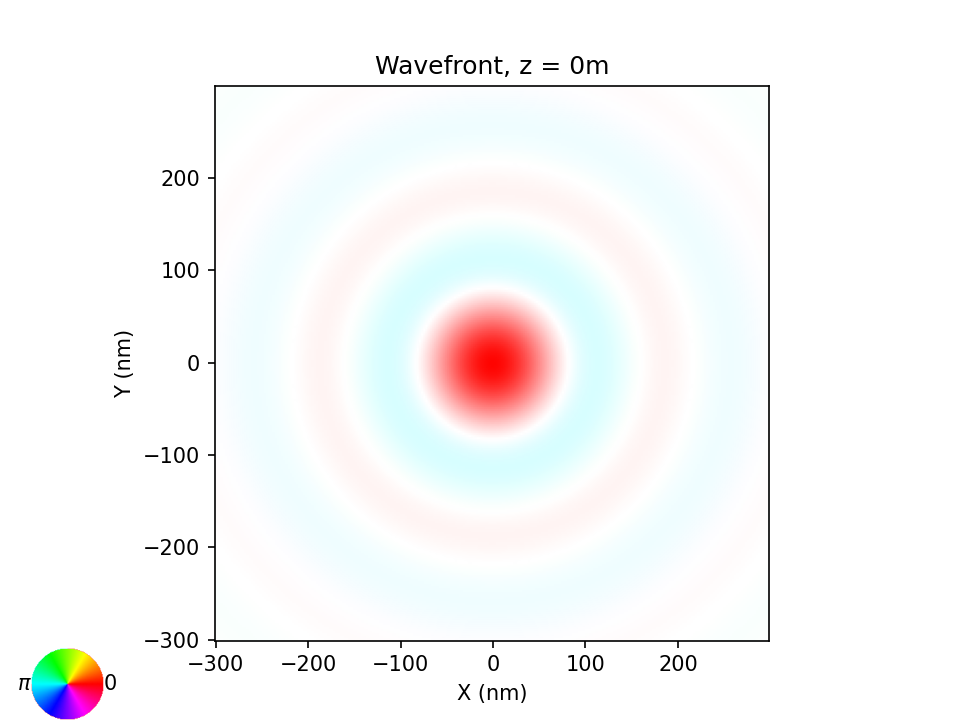

In [4]:
if False:
    # Use probe from a ptychography experiment
    h5data = h5.File("/users/favre/201809-id01-GeSn/data/analysis/ResultsScan0039/latest.cxi")
    w = wavefront.Wavefront(d=fftshift(h5data['/entry_1/probe/data'][0]), 
                            pixel_size=h5data['/entry_1/probe/x_pixel_size'][()],
                            wavelength=wavelength)
    h5data.close()
    w = wavefront.PropagateNearField(150e-6) * w  # Move to focus (+150µm)
    #pr = wavefront.PropagateNearField(50e-6) * w  # Move around focus
    w = wavefront.FreePU() * w  
    #plt.xlim(-.2, .2)
    #plt.ylim(-.2, .2)
    prx, pry = w.get_x_y()
    prx = fftshift(prx)
    pry = fftshift(pry)
    pr = w.get(shift=True)[0]
else:
    # Simulate FZP
    delta_min = 70e-9
    rmax = np.float32(150e-6)  # radius of FZP
    focal_length = 2 * rmax * delta_min / wavelength
    print("FZP: diameter= %6.2fum, focal length=%6.2fcm" % (rmax * 2 * 1e6, focal_length * 100))
    nr, ntheta = np.int32(1024), np.int32(512)  # number of points for integration on FZP
    r_cs = np.float32(25e-6)  # Central stop radius
    osa_z, osa_r = np.float32(focal_length - .021), np.float32(30e-6)  # OSA position and radius
    sourcez = -90
    focal_point = 1 / (1 / focal_length - 1 / abs(sourcez))

    prx = np.linspace(-.3e-6, .3e-6, 256)
    pry = np.linspace(-.3e-6, .3e-6, 256)[:, np.newaxis]

    pr, dt, flop = fzp.FZP_thread(prx, pry, focal_point, sourcex=0, sourcey=0, sourcez=sourcez, 
                                  wavelength=wavelength, focal_length=focal_length, rmax=rmax, 
                                  r_cs=r_cs, osa_z=osa_z, osa_r=osa_r, nr=nr, ntheta=ntheta,
                                  gpu_name="gpu", verbose=False)
    print("clFZP dt=%9.5fs, %8.2f Gflop/s" % (dt, flop / 1e9 / dt))
    w = wavefront.Wavefront(d=fftshift(pr), pixel_size=(prx.max()-prx.min()) / (pr.shape[-1] - 1),
                             wavelength=wavelength)

w = wavefront.ImshowRGBA() * w

## Compute scattering from different positions of the beam on the crystal
The beam illumination is first interpolated on the position of each scattering unit cell of the crystal,
and then the scattering is computed on the GPU.

The number of positions for the beam can be changed using `ndx` and `ndy`

In [5]:
rgi = RegularGridInterpolator((prx.flatten(), pry.flatten()), pr, method='linear', bounds_error=False, fill_value=0)

ndx, ndy = 5, 5

vdx, vdy = np.linspace(x.min(), x.max(), ndx), np.linspace(y.min(), y.max(), ndy)
v = []
for idy in range(ndy):
    for idx in range(ndx):
        dx, dy = vdx[idx], vdy[idy]
        rho = rgi(np.concatenate(((x-dx).reshape(1, x.size), (y-dy).reshape(1, y.size))).transpose()).reshape(y.shape).astype(np.complex64)

        # Scattering from crystal on 2D detector
        fhkl_real, dt = Fhkl_thread(sx, sy, sz, x, y, z, occ=rho.real, gpu_name=gpu_name, language=language)
        fhkl_imag, dt = Fhkl_thread(sx, sy, sz, x, y, z, occ=rho.imag, gpu_name=gpu_name, language=language)
        print("dx =%4.0fnm, dy =%4.0fnm, dt = %6.2fs" % (dx * 1e9, dy * 1e9, 2*dt))
        fhkl = fhkl_real + 1j * fhkl_imag
        v.append({'dx': dx, 'dy': dy, 'fhkl': fhkl})


dx =-269nm, dy =-141nm, dt =   0.48s
dx =-134nm, dy =-141nm, dt =   0.48s
dx =   0nm, dy =-141nm, dt =   0.48s
dx = 134nm, dy =-141nm, dt =   0.49s
dx = 269nm, dy =-141nm, dt =   0.49s
dx =-269nm, dy = -71nm, dt =   0.48s
dx =-134nm, dy = -71nm, dt =   0.48s
dx =   0nm, dy = -71nm, dt =   0.48s
dx = 134nm, dy = -71nm, dt =   0.48s
dx = 269nm, dy = -71nm, dt =   0.48s
dx =-269nm, dy =  -1nm, dt =   0.49s
dx =-134nm, dy =  -1nm, dt =   0.48s
dx =   0nm, dy =  -1nm, dt =   0.48s
dx = 134nm, dy =  -1nm, dt =   0.48s
dx = 269nm, dy =  -1nm, dt =   0.48s
dx =-269nm, dy =  68nm, dt =   0.48s
dx =-134nm, dy =  68nm, dt =   0.49s
dx =   0nm, dy =  68nm, dt =   0.49s
dx = 134nm, dy =  68nm, dt =   0.48s
dx = 269nm, dy =  68nm, dt =   0.48s
dx =-269nm, dy = 138nm, dt =   0.49s
dx =-134nm, dy = 138nm, dt =   0.49s
dx =   0nm, dy = 138nm, dt =   0.48s
dx = 134nm, dy = 138nm, dt =   0.48s
dx = 269nm, dy = 138nm, dt =   0.48s


## Plot scattering patterns

<IPython.core.display.Javascript object>


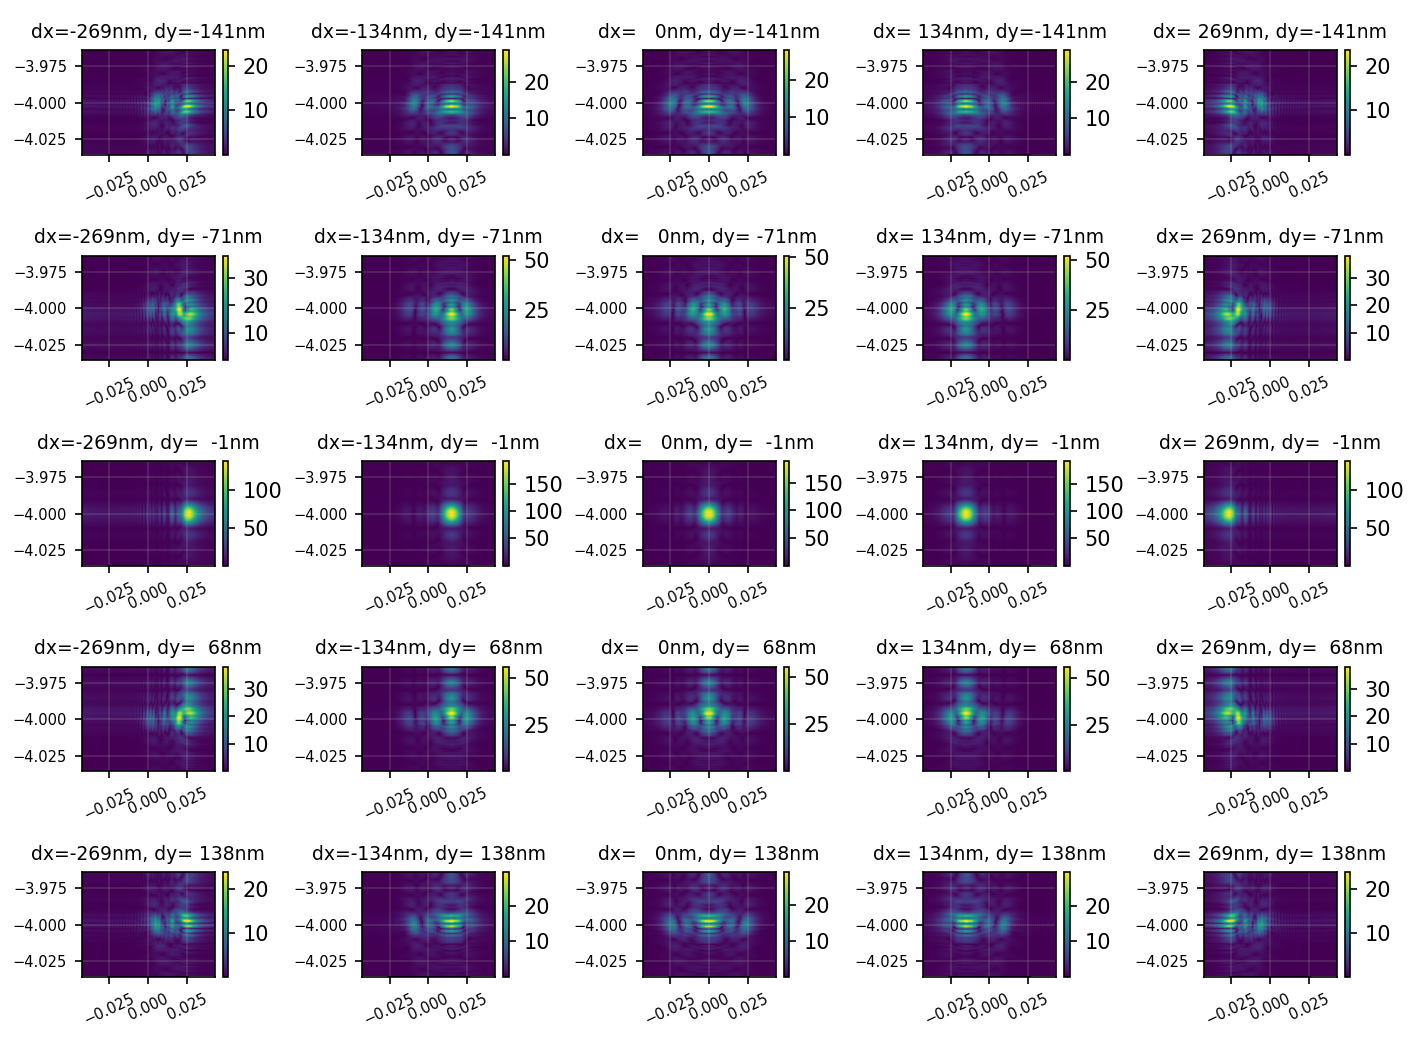

/var/folders/qw/bqj0rhjx27g5zf6v_bywn1jw0000gn/T/ipykernel_18646/2919199295.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(h, k, abs(v[i]['fhkl']))


In [6]:
plt.figure(figsize=(9.5,7))
for i in range(len(v)):
    ax = plt.subplot(ndx, ndy, i + 1)
    plt.title("dx=%4.0fnm, dy=%4.0fnm" % (dx * 1e9, dy * 1e9), fontdict={'fontsize':9})
    #plt.imshow(abs(fhkl), norm=LogNorm(vmin=0.1), origin='lower')
    #plt.pcolormesh(h, k, abs(fhkl), norm=LogNorm(vmin=0.5))
    plt.pcolormesh(h, k, abs(v[i]['fhkl']))
    plt.colorbar()
    plt.title("dx=%4.0fnm, dy=%4.0fnm" % (v[i]['dx'] * 1e9, v[i]['dy'] * 1e9), fontdict={'fontsize':9})
    plt.grid(True, alpha=0.2)
    ax.tick_params(axis='y', which='major', labelsize=7)
    ax.tick_params(axis='x', which='major', labelsize=7, labelrotation=25)

plt.tight_layout()


## Back-Fourier transform of the complex field
This shows the wavefront at the exit of the nano-crystal, projected along the axis towards the detector.

First compute the real-space pixel size.

In [7]:
pixel_size_back_propagation = wavelength *  distance / (nxd * pixel_size)
print("Back-propagated pixel size: %6.2fnm"% (pixel_size_back_propagation*1e9))

Back-propagated pixel size:   6.34nm


Plot the back-propagated wavefront, with axes in nanometers:

<IPython.core.display.Javascript object>


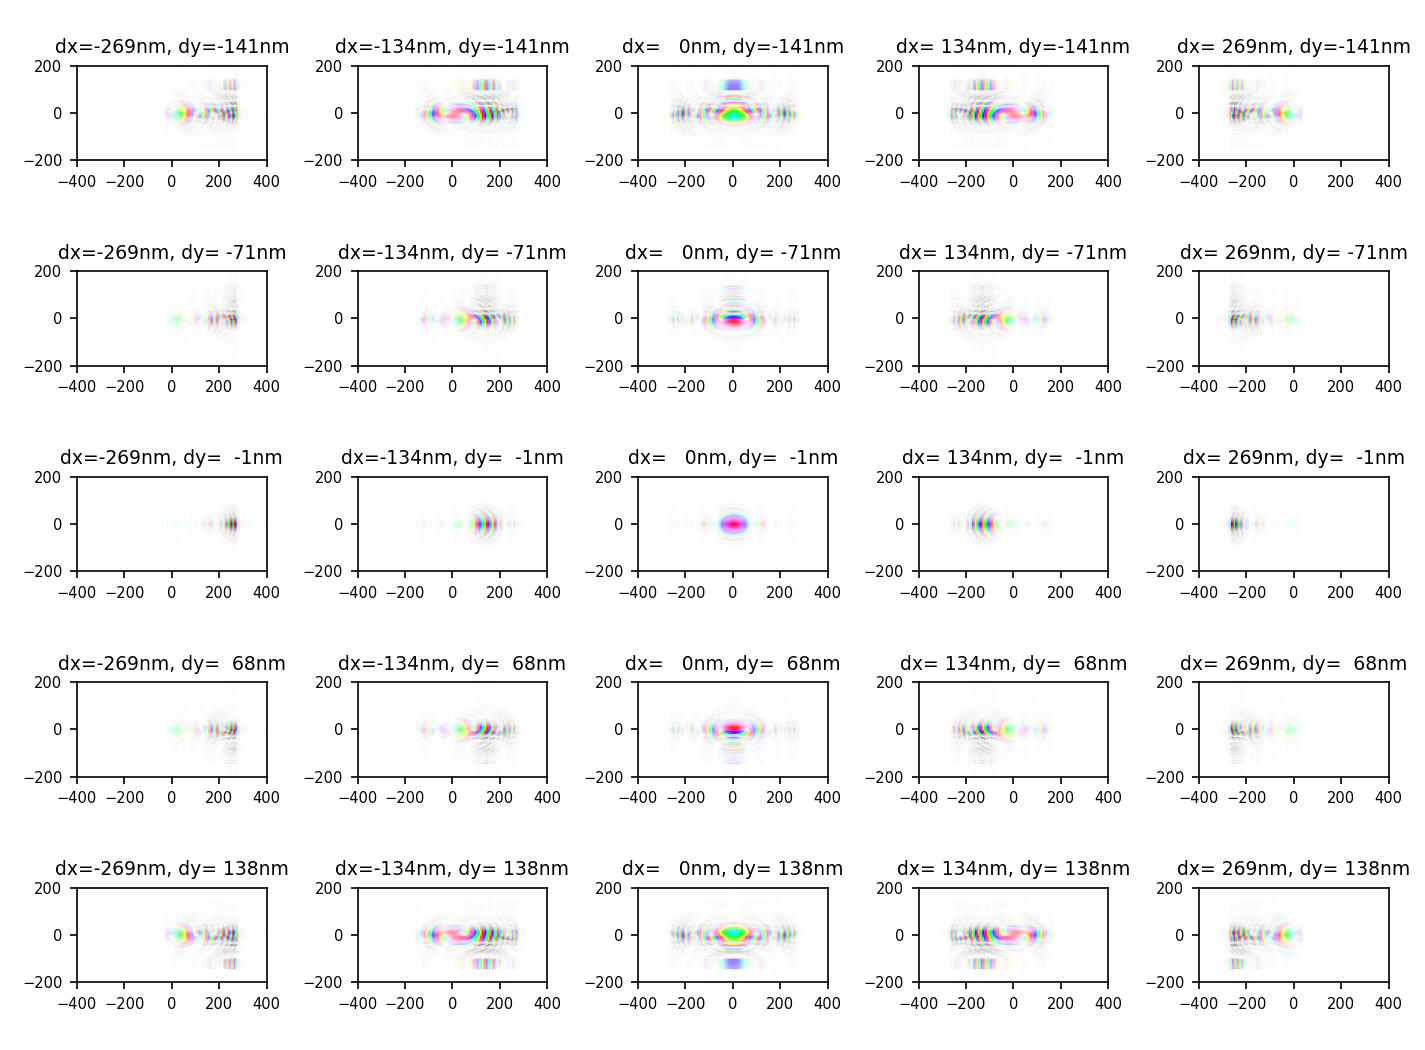

In [8]:
plt.figure(figsize=(9.5,7))
ax = nxd * pixel_size_back_propagation /2 * 1e9
ay = nyd * pixel_size_back_propagation /2 * 1e9
ex = (-ax,ax,-ay,ay)
for i in range(len(v)):
    ax = plt.subplot(ndx, ndy, i + 1)
    plt.imshow(complex2rgbalin(fftshift(ifftn(fftshift(v[i]['fhkl'])))), extent=ex)
    plt.title("dx=%4.0fnm, dy=%4.0fnm" % (v[i]['dx'] * 1e9, v[i]['dy'] * 1e9), fontdict={'fontsize':9})
    #plt.xlim(200,320)  # in pixels
    #plt.ylim(220,290)  # in pixels
    plt.xlim(-400,400)
    plt.ylim(-200,200)
    ax.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()